# Summary : File for training the  posenet coordinates and generating the model for classification.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.optimizers import SGD, Adam, Adadelta, RMSprop

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [61]:
#Provide link to the dataset from google drive. 
df = pd.read_csv("/content/sample_data/dataset.csv")

In [62]:
df.head()

,Unnamed: 0,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,target
0,0,0.581017,0.453762,0.577404,0.450055,0.580916,0.438998,0.535544,0.451611,0.532621,...,0.633268,0.457303,0.783270,0.467570,0.733809,0.613938,0.862114,0.601431,0.804750,downdog
1,1,0.672227,0.420998,0.676045,0.457124,0.677759,0.436243,0.633316,0.499608,0.633656,...,0.198734,0.518366,0.199355,0.475942,0.110195,0.712224,0.115352,0.707583,0.107450,downdog
2,2,0.354110,0.370871,0.406322,0.421844,0.415477,0.412413,0.402504,0.448628,0.377361,...,0.439644,0.637481,0.629714,0.632584,0.307768,0.646537,0.668065,0.703895,0.305129,downdog
3,3,0.619298,0.383468,0.619082,0.363149,0.620133,0.361472,0.565902,0.343289,0.564115,...,0.604139,0.493288,0.752428,0.512264,0.706776,0.710683,0.896842,0.694093,0.817436,downdog
4,4,0.725169,0.466298,0.726078,0.453241,0.726422,0.454009,0.695704,0.427014,0.698670,...,0.604987,0.638270,0.717947,0.637848,0.717494,0.769706,0.808502,0.755783,0.798569,downdog


In [63]:
df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

In [64]:
#Cleaning the data => Removing columns with nose, ear and eye
points_to_remove = ['nose','ear','eye']
for c in df.columns:
       for point in points_to_remove:
         if(point in c):
           print("Drop : ",c)
           df.drop(c, axis=1, inplace=True)

Drop :  nose_x
Drop :  nose_y
Drop :  left_eye_x
Drop :  left_eye_y
Drop :  right_eye_x
Drop :  right_eye_y
Drop :  left_ear_x
Drop :  left_ear_y
Drop :  right_ear_x
Drop :  right_ear_y


In [65]:
df.shape
#25 columns in the data frame => taking 24 co ordinates to detect a pose

(464, 25)

In [66]:
df.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'left_knee_x', 'left_knee_y', 'right_knee_x',
       'right_knee_y', 'left_ankle_x', 'left_ankle_y', 'right_ankle_x',
       'right_ankle_y', 'target'],
      dtype='object')

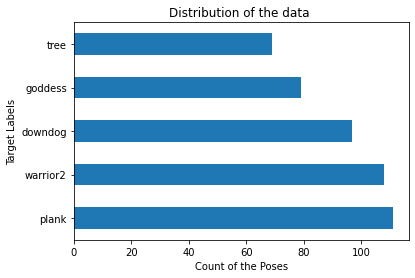

In [67]:
#Showing the number of images present for each yoga pose 
df.target.value_counts().plot(kind='barh')
plt.title("Distribution of the data ")
plt.xlabel("Count of the Poses")
plt.ylabel("Target Labels")
plt.show()

In [68]:
#Separating input(X=>all the coordinates of joints) and output(Y=>pose) data 
X = df.drop(columns=['target'])
y_temp = df['target']

In [69]:
#Encoding the target variables with labels for each class 
le = preprocessing.LabelEncoder()
y = le.fit_transform(y_temp)

In [70]:
#showing labels assigned to each pose 
poses = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
encoded_data, mapping_index = pd.Series(poses).factorize()
for data in encoded_data:
    print(data, mapping_index[data])

0 downdog
1 goddess
2 plank
3 tree
4 warrior2


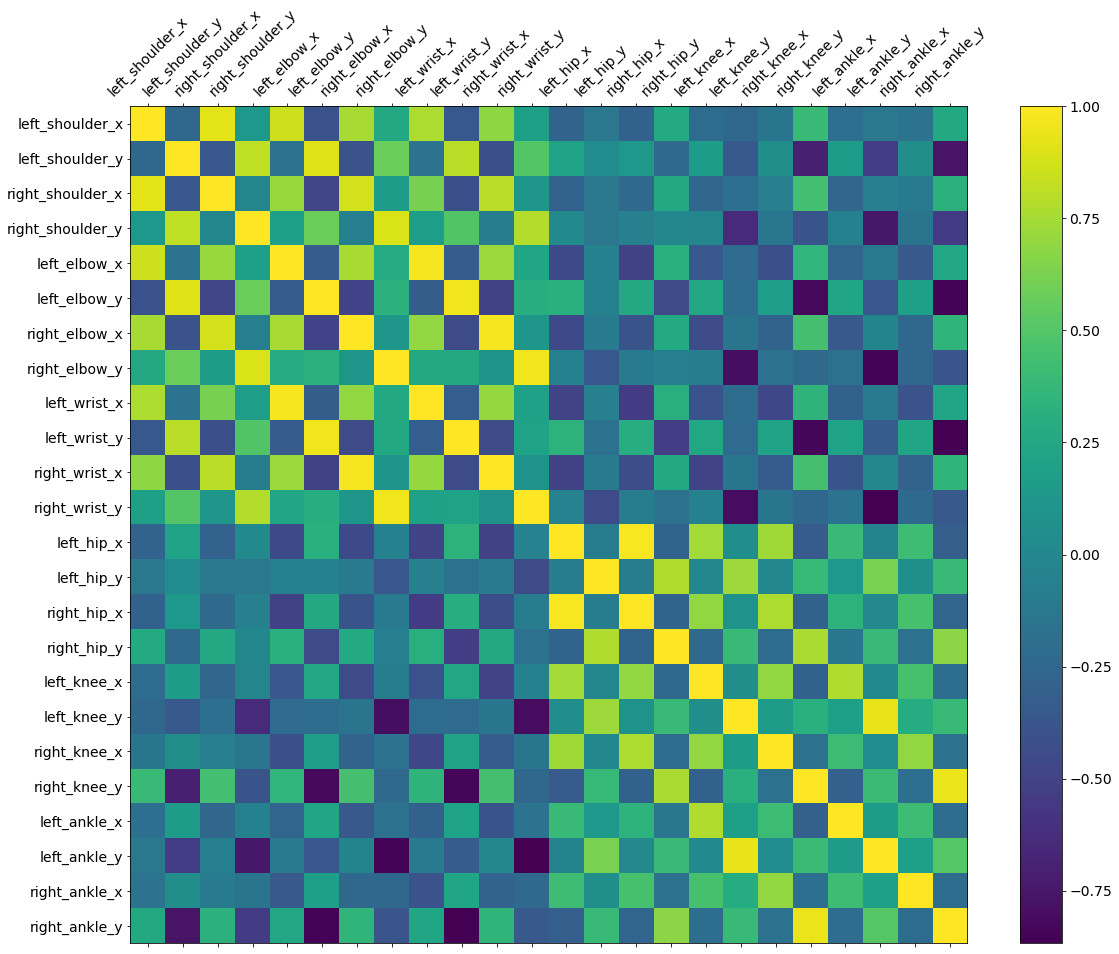

In [71]:
#plotting the correlation matrix 
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
search = '_x'

plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#Training Model

In [60]:
#splitting the train and test datas 
X_dev, X_test, y_dev, y_test = train_test_split( X, y, test_size=0.20, random_state=42)
#Splitting the data into validation and train test
X_train, X_val, y_train, y_val = train_test_split( X_dev, y_dev, test_size=0.20, random_state=42)

In [32]:
print("Shape of the dataset")
print("Train ", X_train.shape)
print("Test ", X_test.shape)
print("Validation ", X_val.shape)
input_shape = X_train.shape

Shape of the dataset
Train  (296, 24)
Test  (93, 24)
Validation  (75, 24)


In [72]:
#Building custom model 
model = Sequential()
model.add(Dense(24,  activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(32, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(24, activation = "softmax"))
model.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
model.build(input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (296, 24)                 600       
                                                                 
 dense_35 (Dense)            (296, 64)                 1600      
                                                                 
 dropout_7 (Dropout)         (296, 64)                 0         
                                                                 
 dense_36 (Dense)            (296, 32)                 2080      
                                                                 
 dense_37 (Dense)            (296, 64)                 2112      
                                                                 
 dense_38 (Dense)            (296, 32)                 2080      
                                                                 
 dropout_8 (Dropout)         (296, 32)                

In [74]:
model.fit(X_train, y_train, verbose=1, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
10/10 [==============================] - 1s 20ms/step - loss: 2.4524 - accuracy: 0.2061 - val_loss: 1.9054 - val_accuracy: 0.1067
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 1.7961 - accuracy: 0.1993 - val_loss: 1.5378 - val_accuracy: 0.3333
Epoch 3/50
10/10 [==============================] - 0s 4ms/step - loss: 1.5654 - accuracy: 0.3311 - val_loss: 1.3939 - val_accuracy: 0.2667
Epoch 4/50
10/10 [==============================] - 0s 6ms/step - loss: 1.2423 - accuracy: 0.4223 - val_loss: 1.0729 - val_accuracy: 0.4667
Epoch 5/50
10/10 [==============================] - 0s 4ms/step - loss: 1.0583 - accuracy: 0.5236 - val_loss: 1.1993 - val_accuracy: 0.4000
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 1.1337 - accuracy: 0.4527 - val_loss: 0.8699 - val_accuracy: 0.6533
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.9882 - accuracy: 0.5372 - val_loss: 0.8574 - val_accuracy: 0.6267
Epoch 8/50
10/10 [=

In [77]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_matrix(y_test, y_pred_classes)

3/3 [==============================] - 0s 3ms/step


array([[27,  0,  0,  0,  0],
       [ 0,  6,  1,  1,  1],
       [ 0,  0, 16,  0,  0],
       [ 0,  1,  0,  7,  0],
       [ 0,  5,  0,  1, 27]])

In [78]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.50      0.67      0.57         9
           2       0.94      1.00      0.97        16
           3       0.78      0.88      0.82         8
           4       0.96      0.82      0.89        33

    accuracy                           0.89        93
   macro avg       0.84      0.87      0.85        93
weighted avg       0.91      0.89      0.90        93



In [ ]:
#Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")